#Preload the dataset, import libraries

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaungkhantkyaw2003","key":"8dda3e279dbf5e04fdcfa6e3d7524338"}'}

In [4]:
# Set up Kaggle API key for downloading datasets
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # Copy kaggle.json to the Kaggle config directory
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for security

In [5]:
!kaggle datasets download -d algord/fake-news

Dataset URL: https://www.kaggle.com/datasets/algord/fake-news
License(s): CC0-1.0
  0% 0.00/1.68M [00:00<?, ?B/s]
100% 1.68M/1.68M [00:00<00:00, 134MB/s]


In [7]:
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: FakeNewsNet.csv         


In [28]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
wnl=WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation, preprocessing

In [8]:
data = pd.read_csv('../content/FakeNewsNet.csv')
data

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [9]:
print(len(data))

23196


#### This code cleans the dataset by removing duplicate and missing rows. It calculates counts of real and fake news articles and uses Plotly to create a pie chart visualizing their distribution and it prints the counts of real and fake news articles.

In [10]:
# Duplicate and missing values
# Drop duplicate rows based on all columns
data = data.drop_duplicates()

# Remove rows with missing values
data = data.dropna()

# Display the updated DataFrame
print(len(data))

22730


In [11]:
import plotly.express as px

# Assuming 'real' column represents whether the news is real (1) or fake (0)
# Count the number of real and fake news articles
real_news_count = data[data['real'] == 1].shape[0]
fake_news_count = data[data['real'] == 0].shape[0]

# Create a pie chart
fig = px.pie(
    names=['Real', 'Fake'],
    values=[real_news_count, fake_news_count],
    title='Distribution of Real and Fake News'
)

fig.show()
real_news_count = data[data['real'] == 1].shape[0]
fake_news_count = data[data['real'] == 0].shape[0]

print(f"Real news count: {real_news_count}")
print(f"Fake news count: {fake_news_count}")

Real news count: 17327
Fake news count: 5403


#### In this part of the project, I created two functions to clean up text data and extract relevant information from source URLs. My preprocess function takes each title, removes punctuation, converts words to lowercase, and lemmatizes them to reduce words to their base forms. I also removed common stop words to retain only the most meaningful terms. For the extract_source function, I focused on isolating the primary domain from each source URL, keeping just the main identifier. After applying these functions, I stored the cleaned titles in a new column, preprocessed_title, and the main domain names in source_domain.

Lemmatization is a text preprocessing technique used to reduce words to their base form, which represents the dictionary version of a word. Lemmatization uses vocabulary and morphological analysis to return a linguistically correct base form.

In [12]:
# preprocess
def preprocess(sent):
  for char in "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~":
    sent=sent.replace(char,'')

  words=sent.split()

  for i in range(len(words)):
    words[i]=words[i].lower()
    words[i]=wnl.lemmatize(words[i])

  new_words=[]
  for word in words:
    if word not in stop_words:
      new_words.append(word)

  return new_words

# extract source
def extract_source(source_domain):
  if source_domain.count('.')>1:
    return source_domain.split('.')[1]
  else:
    return source_domain.split('.')[0]

data['preprocessed_title']=data['title'].apply(preprocess)
data['source_domain']=data['source_domain'].apply(extract_source)
data['source_domain'].value_counts()

,count
source_domain,
people,1779
dailymail,957
wikipedia,738
usmagazine,704
etonline,659
...,...
soberinfo,1
momcurls,1
glamseamless,1


In [ ]:
data.head()

,title,news_url,source_domain,tweet_num,real,preprocessed_title
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab,42,1,"[kandi, burruss, explodes, rape, accusation, r..."
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,today,0,1,"[people, choice, award, 2018, best, red, carpe..."
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,etonline,63,1,"[sophia, bush, sends, sweet, birthday, message..."
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,dailymail,20,1,"[colombian, singer, maluma, spark, rumour, ina..."
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,zerchoo,38,1,"[gossip, girl, 10, year, later, upper, east, s..."


#Train test split, extracting titles

#### In this step, I started by splitting the dataset into training and testing sets, reserving 80% for training and 20% for testing. Since my dataset has a class imbalance, I needed a way to ensure the model learns effectively from both classes. To address this, I created a compute_class_weights function that calculates weights for each class based on their occurrence in the training data. By applying it to train_data['real'], I could assign higher weights to underrepresented classes, helping the model treat them with balanced importance.

In [13]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [14]:
from collections import Counter

def compute_class_weights(y):
    counts = Counter(y)
    total = sum(counts.values())
    class_weights = {cls: total / (len(counts) * count) for cls, count in counts.items()}
    return class_weights

class_weights = compute_class_weights(train_data['real'])
print(class_weights)


{1: 0.6562725566623357, 0: 2.099769053117783}


####Here, I focused on preparing the titles and source domains for model input. I first extracted the preprocessed titles from the training and test sets, then trained a Word2Vec model on the training titles to create word embeddings. After that, I used a Tokenizer to convert these titles to sequences of word indices, establishing a vocabulary and sequence length.Next, I created an embedding matrix where each index from the tokenizer is mapped to its Word2Vec vector representation. This matrix will be useful for the embedding layer in the model. To ensure uniform input sizes, I padded the title sequences to the maximum sequence length found in the data.For the source domains, I used one-hot encoding to transform the domains into binary feature vectors. Then, I checked how many source domains in the test set were not seen during training (unknown sources) and printed the count.

In [15]:
# Extract titles
train_titles = train_data['preprocessed_title']
test_titles = test_data['preprocessed_title']

# Train Word2Vec model
w2v_model = Word2Vec(sentences=train_titles, vector_size=100, min_count=1, window=3)

# Initialize and fit Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_titles)

# Convert titles to sequences
train_sequences = tokenizer.texts_to_sequences(train_titles)
test_sequences = tokenizer.texts_to_sequences(test_titles)

# Define max sequence length and word index size
max_len = max(map(len, train_sequences))
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[index] = w2v_model.wv[word]

# Pad sequences
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')


In [16]:
# One-hot encode source domains
ohe = OneHotEncoder(handle_unknown='ignore')
train_source_encoded = ohe.fit_transform(train_data[['source_domain']]).toarray()
test_source_encoded = ohe.transform(test_data[['source_domain']]).toarray()

# Calculate unknown sources in test set
unknown_sources_count = (test_source_encoded.sum(axis=1) == 0).sum()
print('The number of unknown sources:', unknown_sources_count)


The number of unknown sources: 283


#Models

## First Model
In this step, I set up and trained an LSTM model for binary classification of news authenticity. I began by splitting the data into training and validation sets, using 80% of the data for training and 20% for validation. Then, I built a Sequential model with an embedding layer (using the pre-trained Word2Vec embedding matrix), followed by an LSTM layer to capture sequential patterns, and a dense output layer with a sigmoid activation function for binary classification.

After compiling the model with the Adam optimizer and binary cross-entropy loss, I applied early stopping to prevent overfitting. I trained the model for 20 epochs, using class weights to address the class imbalance in the data, and validated it with the validation set.

To evaluate the model, I plotted the training and validation loss curves to visually track the model’s learning process. I also predicted the labels for the test set, applying a threshold of 0.5 to convert probabilities into binary predictions. Finally, I used the classification report to evaluate the model’s performance, including precision, recall, and F1-score.

In [18]:
# modeling
train_target=np.array(train_data['real'])
test_target=np.array(test_data['real'])

# split train and validation data
Train_sequences_padded, Val_sequences_padded, Train_target, Val_target=train_test_split(train_sequences_padded, train_target, test_size=0.2, random_state=42)

model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=False))
model.add(LSTM(32))
model.add(Dense(units=1, activation='sigmoid'))
model.build(input_shape=(None, 35))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping=EarlyStopping(patience=5, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 35, 100)             │       1,829,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,846,957 (7.05 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 1,829,900 (6.98 MB)

In [19]:
history=model.fit(Train_sequences_padded, Train_target, epochs=20, batch_size=32, class_weight=class_weights, callbacks=[early_stopping], validation_data=[Val_sequences_padded, Val_target])

Epoch 1/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5771 - loss: 0.6703 - val_accuracy: 0.6808 - val_loss: 0.6576
Epoch 2/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.7075 - loss: 0.6257 - val_accuracy: 0.7490 - val_loss: 0.5920
Epoch 3/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7309 - loss: 0.6085 - val_accuracy: 0.6844 - val_loss: 0.6364
Epoch 4/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7228 - loss: 0.6082 - val_accuracy: 0.7734 - val_loss: 0.5547
Epoch 5/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.7392 - loss: 0.6058 - val_accuracy: 0.7305 - val_loss: 0.6049
Epoch 6/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7284 - loss: 0.6048 - val_accuracy: 0.7712 - val_loss: 0.5536
Epoch 7/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7327 - loss: 0.6021 - val_accuracy: 0.7044 - val_loss: 0.6149
Epoch 8/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7421 - loss: 0.5975 - v

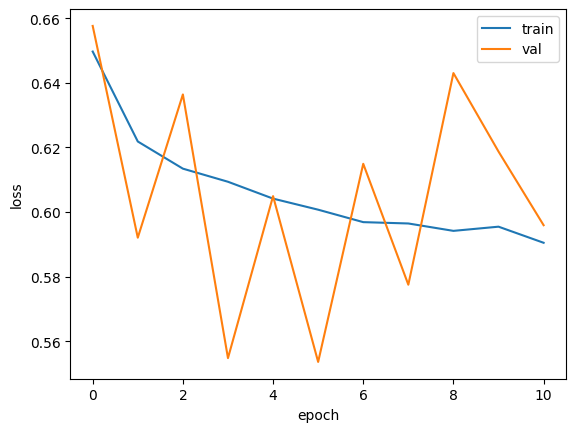

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [21]:
# model evaluation
threshold=0.5
test_pred_prob=model.predict(test_sequences_padded)
test_pred=np.zeros(test_target.shape)
for i in range(test_pred_prob.shape[0]):
  if test_pred_prob[i]>=threshold:
    test_pred[i]=1

print(classification_report(test_target, test_pred))

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      1073
           1       0.84      0.86      0.85      3473

    accuracy                           0.77      4546
   macro avg       0.68      0.67      0.67      4546
weighted avg       0.76      0.77      0.77      4546



## Second Model
In this part of the project, I took a more advanced approach by combining both the title and source domain information to train the model. I first merged the padded title sequences and the one-hot encoded source domain features into a single input array. After splitting this into training and validation sets, I separated the title sequences and source encodings for later use in the model.

For the model architecture, I created two separate input branches:
Title Model: The first branch processes the title input using an embedding layer followed by an LSTM layer to capture sequential dependencies.
Source Model: The second branch processes the source domain input through a dense layer to capture domain-related patterns.
I then concatenated the outputs of both branches and passed them through a final dense layer with a sigmoid activation for binary classification.

The model was compiled using the Adam optimizer and binary cross-entropy loss. I also used early stopping to monitor for overfitting. The model was trained for 20 epochs, and I incorporated class weights to handle any class imbalance. The training and validation data were used to evaluate the model’s performance during training.

After training, I predicted labels for the test set using the trained model and applied a threshold of 0.5 to convert probabilities to binary predictions. Finally, I used the classification report to assess the model's performance, focusing on metrics like precision, recall, and F1-score.








In [22]:
#title and source
#modeling
# split train and validation data
train_x=np.concatenate((train_sequences_padded, train_source_encoded), axis=1)
Train_x, Val_x, Train_target, Val_target=train_test_split(train_x, train_target, test_size=0.2, random_state=42)
Train_sequences_padded=Train_x[:, :max_len]
Val_sequences_padded=Val_x[:, :max_len]
Train_source_encoded=Train_x[:, max_len:]
Val_source_encoded=Val_x[:, max_len:]

# title model
title_input=Input(shape=(max_len,), name="title_input")
embedding_layer=Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=False)(title_input)
title_output=LSTM(32)(embedding_layer)

# source model
source_input=Input(shape=(Train_source_encoded.shape[1],), name="source_input")
source_output=Dense(units=16, activation='relu')(source_input)

# final model
inputs=Concatenate()([title_output, source_output])
output=Dense(units=1, activation='sigmoid')(inputs)
model2=Model(inputs=[title_input, source_input], outputs=output)
model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping=EarlyStopping(patience=5, restore_best_weights=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)  │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 35, 100)        │      1,829,900 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ source_input (InputLayer) │ (None, 1860)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         17,024 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │         29,776 │ source_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 48)             │              0 │ lstm_1[0][0],          │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             49 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,876,749 (7.16 MB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 1,829,900 (6.98 MB)

In [23]:
history=model2.fit([Train_sequences_padded, Train_source_encoded], Train_target, epochs=20, batch_size=32, class_weight=class_weights, callbacks=[early_stopping], validation_data=([Val_sequences_padded, Val_source_encoded], Val_target))

Epoch 1/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6478 - loss: 0.6537 - val_accuracy: 0.7154 - val_loss: 0.6016
Epoch 2/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7921 - loss: 0.5088 - val_accuracy: 0.7743 - val_loss: 0.4947
Epoch 3/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8178 - loss: 0.4597 - val_accuracy: 0.7787 - val_loss: 0.4858
Epoch 4/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8323 - loss: 0.4320 - val_accuracy: 0.7809 - val_loss: 0.4752
Epoch 5/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8263 - loss: 0.4241 - val_accuracy: 0.8125 - val_loss: 0.4280
Epoch 6/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8298 - loss: 0.4091 - val_accuracy: 0.7891 - val_loss: 0.4584
Epoch 7/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8300 - loss: 0.4054 - val_accuracy: 0.7704 - val_loss: 0.4877
Epoch 8/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8294 - loss: 0.3953 - 

In [24]:
# model evaluation
threshold=0.5
test_pred_prob=model2.predict([test_sequences_padded, test_source_encoded])
test_pred=np.zeros(test_target.shape)
for i in range(test_pred_prob.shape[0]):
  if test_pred_prob[i]>=threshold:
    test_pred[i]=1

print(classification_report(test_target, test_pred))

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1073
           1       0.88      0.88      0.88      3473

    accuracy                           0.82      4546
   macro avg       0.75      0.75      0.75      4546
weighted avg       0.82      0.82      0.82      4546



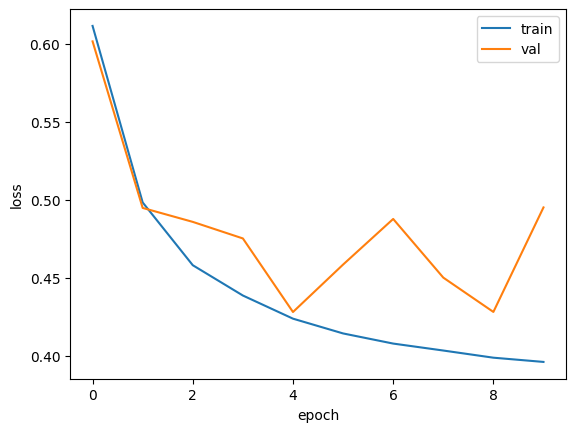

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## Saving Both Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#save both models
model.save('/content/drive/MyDrive/AI_A2/model1.keras')
model2.save('/content/drive/MyDrive/AI_A2/model2.keras')

#SVM Model
In this part of the project, I shifted to using a Support Vector Machine (SVM) model for classification.
Text Preprocessing: I concatenated the preprocessed title tokens into a single string for each news article, making it suitable for vectorization.

TF-IDF Vectorization: I applied the TfidfVectorizer to convert the preprocessed titles into numerical features. This method transforms the text into a matrix of TF-IDF features, where each word’s importance in the document is weighted. I set a limit on the number of features 5000 to control the size of the feature set.

Training the SVM Model: I trained a Support Vector Machine (SVM) model with a linear kernel on the TF-IDF features of the training set. The probability=True parameter allows the model to estimate probabilities.

Model Evaluation: After training, I used the trained model to predict the labels for the test set. To assess its performance, I used classification_report to get key metrics such as precision, recall, and F1-score for both the real and fake news classes.

This approach with TF-IDF and SVM provides an alternative method to the deep learning-based model, and I can compare the results of both to understand which one performs better.

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer


# Concatenate preprocessed titles for SVM
train_titles_str = [' '.join(title) for title in train_data['preprocessed_title']]
test_titles_str = [' '.join(title) for title in test_data['preprocessed_title']]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
train_features = vectorizer.fit_transform(train_titles_str)
test_features = vectorizer.transform(test_titles_str)

# Train SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, train_data['real'])

# Predict on test data
test_predictions = svm_model.predict(test_features)

# Evaluate the model
print(classification_report(test_data['real'], test_predictions))

              precision    recall  f1-score   support

           0       0.76      0.52      0.62      1073
           1       0.87      0.95      0.90      3473

    accuracy                           0.85      4546
   macro avg       0.81      0.73      0.76      4546
weighted avg       0.84      0.85      0.84      4546

